In [4]:
%%capture
import os, sys, pandas as pd, numpy as np
import datetime as dt
from IPython.display import display
path = os.path.abspath('../bin')
if path not in sys.path:
    sys.path.append(path)
%run ../../Personal-Investing/bin/dag.py
%pylab inline

In [5]:
%%HTML
<style>
@media print{
    .input {display:none!important}
    div.primpt {display:none}
    div.output_stderr {display:none}
}
.rendered_html{font-size:small!important;}
em{color:blue}
code{color:blue!important}
</style>

In [6]:
import cvxportfolio as cp
%run ../../Personal-Investing/bin/data

# Abstract

I develop a forecasting model of Futures trading volumes that is a subcomponent of the transaction cost model of \cite{BBDKKNS}. 

# Introduction

The transaction cost model described on [slide 13 of the CVXPortfolio talk](http://stanford.edu/~boyd/papers/pdf/cvx_portfolio_talk.pdf) is
\begin{eqnarray}
    \hat \phi(x) = a|x| + b\sigma \frac{|x|^{3/2}}{V^{1/2}} + c x,
\end{eqnarray}
where
* $x$ is the dollar trade size,
* $\sigma$ is the single period price volatility,
* $V$ is the USD volume traded over the period,
* $a$, $b$, and $c$ are parameters that must be fit to match the particular market being modeled. 

Accurate forecasts of liquidity drivers, $\sigma$ and $V$, are required in order to estimate transaction costs well. 

Volume estimates for Futures, $\hat V(t,\tau,n)$, depend on
* the trade date, $t$,
* the number of business days, $\tau$, between the trade time and the next first notice date, and 
* on whether the contract is the front contract, $n=1$, or the back contract, $n=2$. 

# Data

## Outright

In [1105]:
futuresData = FuturesData()
_=futuresData.db(database='../../Personal-Investing/data/bloomberg.sqlite3')

In [1106]:
liquidityDf = futuresData.offline[['FUT_CUR_GEN_TICKER', 'VOLUME','OPEN_INT']].copy()
liquidityDf.sort_index(axis=1,inplace=True)
liquidityDf = liquidityDf.loc[:,(slice(None),slice(None),slice(1,2))].stack()
liquidityDf.index = liquidityDf.index.droplevel(1)

futuresHist Date Range: 1990-01-01 to 2018-12-26.


In [1108]:
ticker = 'TY Comdty'
dates = [m+"{:02.0f}".format(y) for y in range(8,19) for m in ['H','M','U','Z']]
volume = liquidityDf.xs(ticker,1,1).pivot_table(index='date',columns='FUT_CUR_GEN_TICKER', values='VOLUME')
openInt = liquidityDf.xs(ticker,1,1).pivot_table(index='date',columns='FUT_CUR_GEN_TICKER', values='OPEN_INT')

def standardColumns(columns):
    cols = []
    for col in columns:
        pre,m,d = re.match('(.+)([HMUZ]{1})(.+)',col).groups()
        if len(d)==1:
            d = '1'+d
        cols.append(pre+m+d)
    return cols

volume.columns = standardColumns(volume.columns)
openInt.columns = standardColumns(openInt.columns)

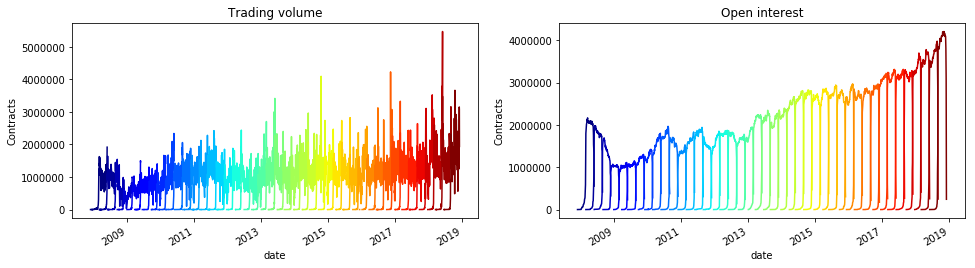

In [1109]:
fig,ax = subplots(1,2,figsize=(16,4))
volume[[ticker.split()[0]+date for date in dates[1:]]].plot(ax=ax[0],title='Trading volume', legend=False,cmap='jet')
handles, labels = ax[0].get_legend_handles_labels()
openInt[[ticker.split()[0]+date for date in dates[1:]]].plot(ax=ax[1], title='Open interest',legend=False,cmap='jet')
for n,a in enumerate(ax):
    a.set_ylabel('Contracts');


In [1110]:
contLiquidityDf = futuresData.offline.copy()
contLiquidityDf.sort_index(axis=1,inplace=True)
contLiquidityDf = contLiquidityDf.loc[:,(slice(None),slice('TY Comdty','TY Comdty'),slice(1,2))][['VOLUME','OPEN_INT']]

## Rolls

In [1057]:
ticker = 'TY Comdty'
bbg = BBG()
mkt = ticker.split()[0]
assetClass = ticker.split()[1]
continuousRollVolume = bbg.getBbgHistData(
    securities=['S:'+mkt+mkt+' 1-2 COMB '+assetClass],
    field='VOLUME',
    start='20000101',
    end='20181231'
)

In [1080]:
rollTickers = []
dates = [m+"{:01.0f}".format(y) for y in range(7,9) for m in ['H','M','U','Z']]

for n,front in enumerate(dates[:-1]):
    back = dates[n+1]
    rollTickers.append('R'+mkt+front+back+' '+assetClass)
rollVolume=bbg.getBbgHistData(
    securities=rollTickers,
    field='VOLUME',
    start='20170101',
    end='20181231'
)
rollVolume.columns = [col.split()[0] for col in rollVolume.columns]

***TY rolls:*** We have continuous roll volume data going back to 2008. We have contract specific roll data going back 2 years for TY. The continuous roll contract volumes are zero after the first notice date.

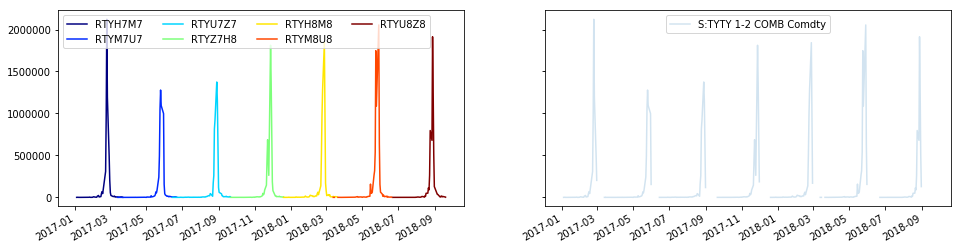

In [1097]:
data = pd.concat({
    'rollVolume':rollVolume,
    'contRollVolume':continuousRollVolume,
},1)
fig,ax=subplots(1,2,figsize=(16,4),sharey=True,sharex=True);
data.rollVolume.dropna(how='all',axis=0).plot(legend=True,cmap='jet',ax=ax[0])
ax[0].legend(ncol=4);
data.contRollVolume.loc[rollVolume.index].plot(ax=ax[1],alpha=.2);

## Roll Adjusted

Here, I adjust the `TY` continuous volume data for the continuous roll volumes to create an adjusted volume series that can be modeled and used as an input to the transaction cost model. Stripping out the roll volumes should more directly relate to transaction costs since the additional volumes associated with calendar rolls are unlikely to cause bid/ask spreads to tighten. 

In [976]:
dateIdx = {}
for date in dates:
    month = re.match('(.*)([0-9]{2})',date).groups()[0]
    ticker = 'TY'+date
    volume[ticker].index

#volume[tickers].dropna(how='all',axis=0).to_excel("../data/TY_roll.xlsx")

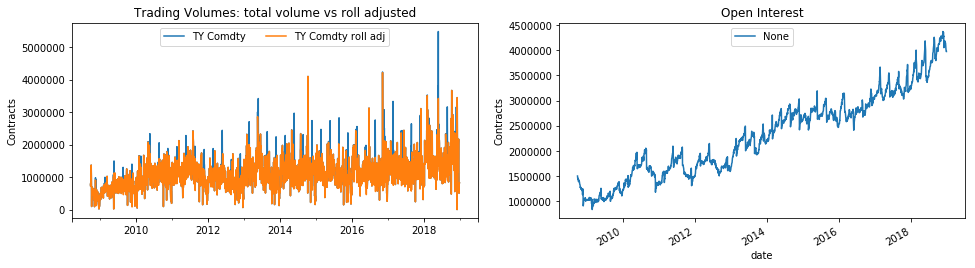

In [1084]:
fig,ax = subplots(1,2,figsize=(16,4))

data = pd.concat({
    ticker:contLiquidityDf.VOLUME.xs(1,1,1).iloc[:,0],
    'roll':continuousRollVolume.iloc[:,0],
},1)['2008-10':]
data[ticker+' roll adj'] = data[ticker]-data.roll.fillna(0.0)
data[[ticker, ticker+' roll adj']].ffill().plot(ax=ax[0],title='Trading Volumes: total volume vs roll adjusted')

openInt['2008-10':].sum(1).plot(ax=ax[1],title='Open Interest')
for n,a in enumerate(ax):
    a.set_ylabel('Contracts');
    a.legend(loc='upper center',ncol=2);

# Analysis
In the charts below you can see a hump like pattern in both trading volumes and in *open interest* that characterizes Futures liquidity through time. Typically, there are only a few days in the lead up to the *first notice date* in which all of the open interest in the *front contract* rolls into the *back contract*. This change in open interest is accompanied, at first, by a spike in front contract trading volumes, partially due to trading of the roll contract, which is then followed by a rapid decline in volumes to near zero after the *first notice date*.  

In [1383]:
df = liquidityDf.stack()[['FUT_CUR_GEN_TICKER', 'OPEN_INT', 'VOLUME']].dropna()
df.reset_index(inplace=True)
lastTradeDate = df.groupby('FUT_CUR_GEN_TICKER').apply(lambda x: x.dropna().date.max())
lastTradeDate.name = 'lastTradeDate'
df = df.join(lastTradeDate, on='FUT_CUR_GEN_TICKER')
df['busDaysToExpiry'] = df.apply(lambda x: np.busday_count(x.date.date(), x.lastTradeDate.date()),axis=1)
pat = '(.+)([FGHJKMNQUVXZ]{1})(.+)'
df['cycle'] = df.apply(lambda row: re.match(pat, row.FUT_CUR_GEN_TICKER).groups()[1],axis=1)

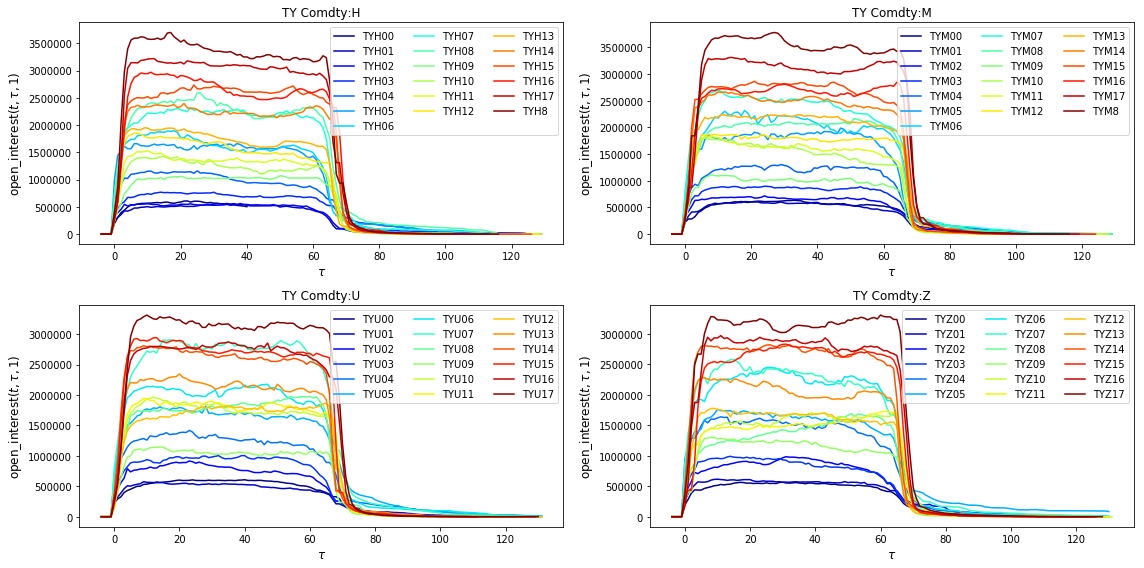

In [1460]:
market = 'TY Comdty'
fig,ax= subplots(2,2,figsize=(16,8))
for n,cycle in enumerate('HMUZ'):
    i,j = int(n/2), n % 2
    query = "date >= '2000-01-01' and date<='2019-12-30' and market=='{market}' and cycle=='{cycle}'"
    query = query.format(market=market, cycle=cycle)
    x= df.query(query)
    x=x[['FUT_CUR_GEN_TICKER', 'busDaysToExpiry', 'OPEN_INT']]
    x = x.pivot(index='busDaysToExpiry', columns='FUT_CUR_GEN_TICKER', values='OPEN_INT').iloc[:,:-1].bfill()
    for k in range(1,5): x.loc[-k,:] = 0.0
    x.sort_index(inplace=True)
    #x=x.mean(1)
    (x).plot(ax=ax[i,j],title='{market}:{cycle}'.format(market=market, cycle=cycle),cmap='jet')
    ax[i,j].legend(ncol=3);
    ax[i,j].set_xlabel(r'$\tau$',size=12);
    ax[i,j].set_ylabel(r'open_interest$(t,\tau,1)$',size=12);    
fig.tight_layout();

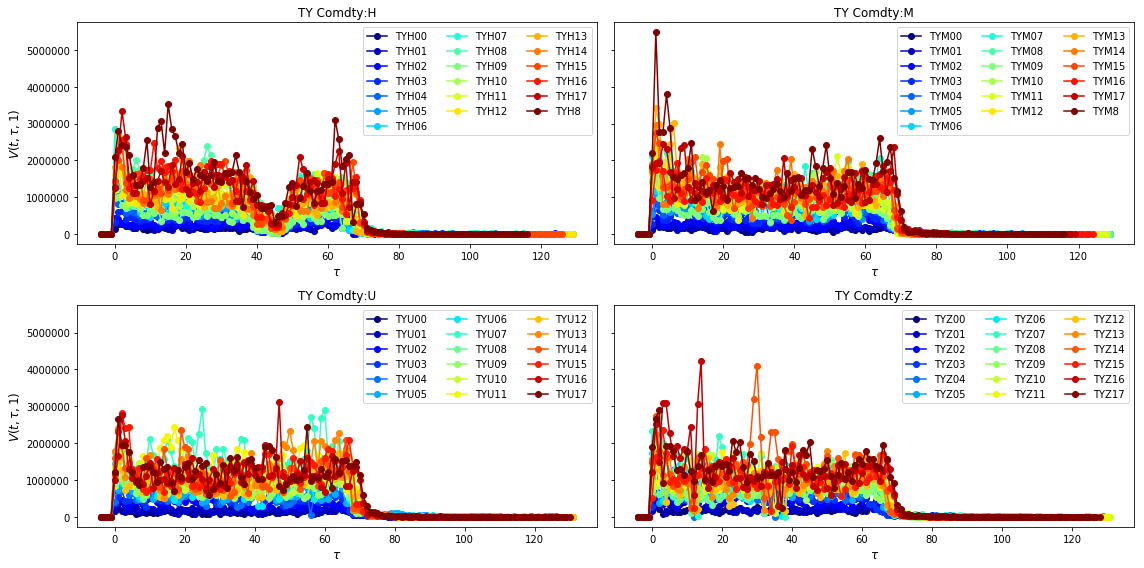

In [1456]:
fig,ax= subplots(2,2,figsize=(16,8), sharey=True)
for n,cycle in enumerate('HMUZ'):
    i,j = int(n/2), n % 2
    query = "date >= '2000-01-01' and date<='2019-12-30' and market ==  '{market}' and cycle=='{cycle}'"
    query = query.format(market=market, cycle=cycle)
    x= df.query(query)
    x=x[['FUT_CUR_GEN_TICKER', 'busDaysToExpiry', 'VOLUME']]
    x = x.pivot(index='busDaysToExpiry', columns='FUT_CUR_GEN_TICKER', values='VOLUME').iloc[:,:-1].bfill()
    for k in range(1,5): x.loc[-k,:] = 0.0
    x.sort_index(inplace=True)
    x.plot(ax=ax[i,j],title=r'{market}:{cycle}'.format(market=market,cycle=cycle),cmap='jet', marker='o')
    ax[i,j].legend(ncol=3);
    ax[i,j].set_xlabel(r'$\tau$',size=12);
    ax[i,j].set_ylabel(r'$V(t,\tau,1)$',size=12);
fig.tight_layout();

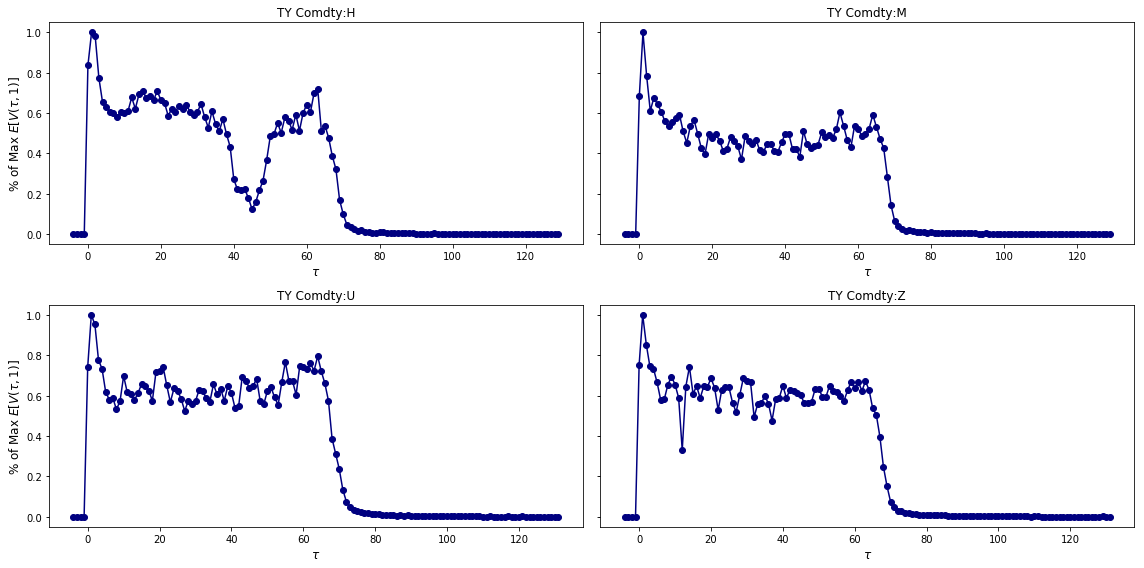

In [1457]:
fig,ax= subplots(2,2,figsize=(16,8), sharey=True)
for n,cycle in enumerate('HMUZ'):
    i,j = int(n/2), n % 2
    query = "date >= '2000-01-01' and date<='2019-12-30' and market ==  '{market}' and cycle=='{cycle}'"
    query = query.format(market=market, cycle=cycle)
    x= df.query(query)
    x=x[['FUT_CUR_GEN_TICKER', 'busDaysToExpiry', 'VOLUME']]
    x = x.pivot(index='busDaysToExpiry', columns='FUT_CUR_GEN_TICKER', values='VOLUME').iloc[:,:-1].bfill()
    for k in range(1,5): x.loc[-k,:] = 0.0
    x.sort_index(inplace=True)
    x=x.mean(1)
    (x/x.max()).plot(ax=ax[i,j],title='{market}:{cycle}'.format(market=market,cycle=cycle),cmap='jet', marker='o')
    ax[i,j].set_ylabel(r'% of Max $E[V(\tau,1)]$',size=12);
    ax[i,j].set_xlabel(r'$\tau$',size=12);
fig.tight_layout();

Suggests a model of the form
$$
    \hat V(t,\tau,1) = E\left[\max_\tau E[V(\tau,1)]\mid \text{oi}(t,\tau,1), \text{oi}(t-1,\tau,1)\right] \frac{E[V(\tau, 1)]}{\max_\tau E[V(\tau,1)]}
$$
where 
* $\delta$ is the year frac of the cycle, e.g., either $\frac{1}{4}$ or $\frac1{12}$
* $r_t$ is the growth factor $r_t = \left(\frac{\max_{\tau}\text{oi}(t-\delta,\tau,1) }{\max_\tau\text{oi}(t-\delta-1,\tau,1) }\right)$.

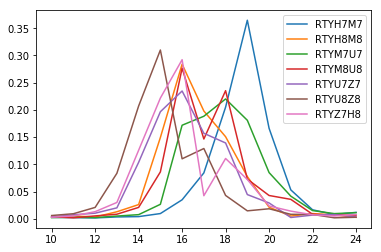

In [894]:
(df/df.cumsum().iloc[-1,:]).round(4).iloc[10:25].plot()

In [406]:
volatilityDf = futuresData.dv.fillna(0.0).rolling(5).std().loc[volumeDf.index,volumeDf.columns.levels[1]]
volatilityDf = (volatilityDf - volatilityDf.rolling(250).mean())/volatilityDf.rolling(250).std()
volatilityDf = volatilityDf.ffill()
volumeDf = pd.concat({
    'FUT_CUR_GEN_TICKER':volumeDf.FUT_CUR_GEN_TICKER,
    'VOLUME':volumeDf.VOLUME,
    'Volatility':volatilityDf,
    'OPEN_INT':volumeDf.OPEN_INT,
},1).loc['2001':,:]

In [416]:
tickers = volumeDf.columns.levels[1]
futs = {}
for ticker in ['ES Index', 'TY Comdty']:
    futs[ticker]={}
    volume = volumeDf.xs(ticker,1,1).pivot_table(index='date',columns='FUT_CUR_GEN_TICKER', values='VOLUME')
    open_int = volumeDf.xs(ticker,1,1).pivot_table(index='date',columns='FUT_CUR_GEN_TICKER', values='OPEN_INT')
    volatility = volumeDf.xs(ticker,1,1).pivot_table(index='date',columns='FUT_CUR_GEN_TICKER', values='Volatility')    
    for contract in volume.columns:
        futs[ticker][contract] = pd.concat({
            'volume':volume[contract], 
            'open_int':open_int[contract],
            'volatility':volatility[contract],
        },1).dropna()
        futs[ticker][contract].index = range(futs[ticker][contract].shape[0])[::-1]
        futs[ticker][contract];
    futs[ticker] = pd.concat(futs[ticker],1)

In [417]:
import re

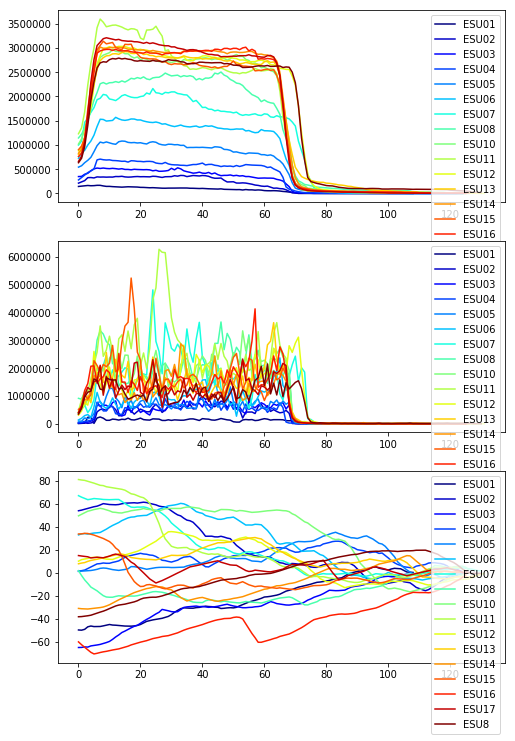

In [418]:
ticker='ES Index'
open_int = futs[ticker].xs('open_int',1,1)
volume = futs[ticker].xs('volume',1,1)
volatility = futs[ticker].xs('volatility',1,1)
pat = re.compile('(.{2})([HMUZ])(.+)')
tickers = []
for col in open_int.columns:
    contract, month, year = re.match(pat,col).groups()
    if month == 'U' and int(year) != 9:
        tickers.append(col)
        
fig,ax=subplots(3,1,figsize=(8,12))
open_int[tickers].plot(cmap='jet',ax=ax[0])
volume[tickers].plot(cmap='jet',ax=ax[1])
volatility[tickers].sort_index(ascending=False).cumsum().plot(cmap='jet',ax=ax[2])

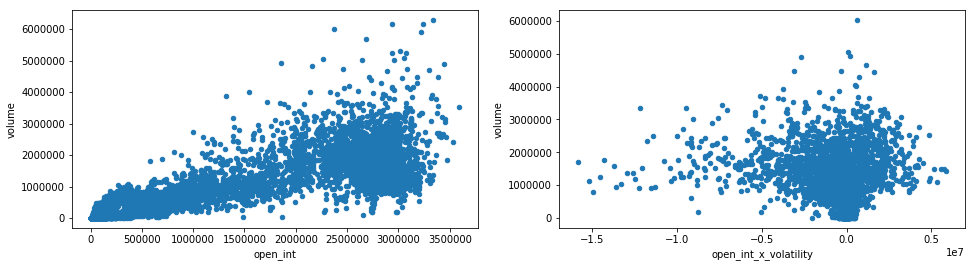

In [429]:
y = futs[ticker].stack(level=0)
y.index = y.index.droplevel()
y['open_int_x_volatility'] = y.open_int * y.apply(log).volatility.shift()
fig,ax = subplots(1,2,figsize=(16,4))
y.plot(kind='scatter', x='open_int', y='volume',ax=ax[0])
y.plot(kind='scatter', x='open_int_x_volatility', y='volume',ax=ax[1])

In [420]:
import statsmodels.api as sm

In [450]:
X = pd.concat({
    'open_int':y.open_int, 
#     'open_int_x_volatility':(y.open_int_x_volatility)
},1)
data = pd.concat({'X':X, 'y':y.volume},1).dropna()
lm = sm.OLS(data.y.volume, sm.add_constant(data.X)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                 2.529e+04
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:17:12   Log-Likelihood:            -1.2981e+05
No. Observations:                8965   AIC:                         2.596e+05
Df Residuals:                    8963   BIC:                         2.596e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.469e+04   6626.951      8.252      0.000    4.17e+04    6.77e+04
open_int       0.6594      0.004    159.044      0.000       0.651       0.668
==============================================================================
Omnibus:                     3776.317   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42328.663
Skew:                           1.709   Prob(JB):                         0.00
Kurtosis:                      13.081   Cond. No.                     2.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

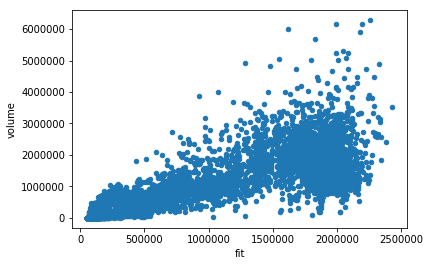

In [451]:
pd.concat({
    'volume':data.y,
    'fit':pd.Series(lm.predict(),index=data.index),
},1).plot(kind='scatter', y='volume', x='fit')

# References

(<a id="cit-BBDKKNS" href="#call-BBDKKNS">Boyd, Busseti <em>et al.</em>, 2017</a>) S. Boyd, E. Busseti, S. Diamond <em>et al.</em>, ``_Multi-Period Trading via Convex Optimization_'',  2017.  [online](http://stanford.edu/~boyd/papers/cvx_portfolio.html)

